<a href="https://colab.research.google.com/github/happyrabbit/IntroDataScience/blob/master/Python/Regression_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from statistics import mean
import statsmodels.api as sm
from sklearn.preprocessing import scale
from statsmodels.nonparametric.smoothers_lowess import lowess
import sklearn.model_selection as ms
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.metrics import mean_squared_error

# Ordinary Least Square

In [262]:
# load data
sim_dat = pd.read_csv("http://bit.ly/2P5gTw4")
sim_dat.head()

,age,gender,income,house,store_exp,online_exp,store_trans,online_trans,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,segment
0,57,Female,120963.400958,Yes,529.134363,303.512475,2,2,4,2,1,2,1,4,1,4,2,4,Price
1,63,Female,122008.104950,Yes,478.005781,109.529710,4,2,4,1,1,2,1,4,1,4,1,4,Price
2,59,Male,114202.295294,Yes,490.810731,279.249582,7,2,5,2,1,2,1,4,1,4,1,4,Price
3,60,Male,113616.337078,Yes,347.809004,141.669752,10,2,5,2,1,3,1,4,1,4,2,4,Price
4,51,Male,124252.552787,Yes,379.625940,112.237177,4,4,4,1,1,3,1,4,1,4,2,4,Price


Before fitting the model, we need to clean the data, such as removing bad data points that are not logical (negative expense).

In [263]:
sim_dat = sim_dat[sim_dat.store_exp >0] 
sim_dat = sim_dat[sim_dat.online_exp > 0]

Use 10 survey question variables as our explanatory variables.

In [264]:
dat = sim_dat.filter(regex = "^Q")

The response variable is the sum of in-store spending and online spending.

In [265]:
# total expense = in store expense + online expense
dat['total_exp'] = sim_dat.store_exp + sim_dat.online_exp
dat.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,total_exp
0,4,2,1,2,1,4,1,4,2,4,832.646838
1,4,1,1,2,1,4,1,4,1,4,587.535491
2,5,2,1,2,1,4,1,4,1,4,770.060313
3,5,2,1,3,1,4,1,4,2,4,489.478756
4,4,1,1,3,1,4,1,4,2,4,491.863117


To fit a linear regression model, let us first check if there are any missing values or outliers:

In [266]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999 entries, 0 to 999
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Q1         999 non-null    int64  
 1   Q2         999 non-null    int64  
 2   Q3         999 non-null    int64  
 3   Q4         999 non-null    int64  
 4   Q5         999 non-null    int64  
 5   Q6         999 non-null    int64  
 6   Q7         999 non-null    int64  
 7   Q8         999 non-null    int64  
 8   Q9         999 non-null    int64  
 9   Q10        999 non-null    int64  
 10  total_exp  999 non-null    float64
dtypes: float64(1), int64(10)
memory usage: 93.7 KB


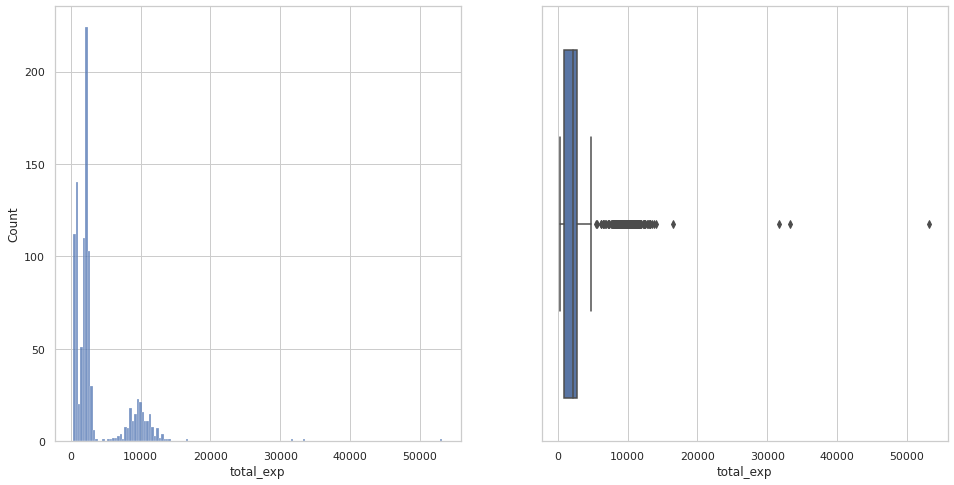

In [267]:

fig, axs = plt.subplots(ncols=2)

fig.set_size_inches(16, 8)
sns.set_theme(style="whitegrid")
sns.histplot(x=dat["total_exp"], ax=axs[0])
sns.boxplot(x=dat["total_exp"], ax=axs[1])

There is no missing value in the response variable, but there are outliers. Outliers are usually best described by the problem to solve itself such that we know from domain knowledge that it is not possible to have such values. We can also use a statistical threshold to remove extremely large or small outlier values from the data. We use the Z-score to find and remove outliers.

In [268]:
# calculate median of the absolute dispersion for total_exp
y = dat.total_exp
ymad = stats.median_absolute_deviation(y)
# calculate z-score
zs = (y - mean(y))/ymad
dat = dat[zs <= 3.5]

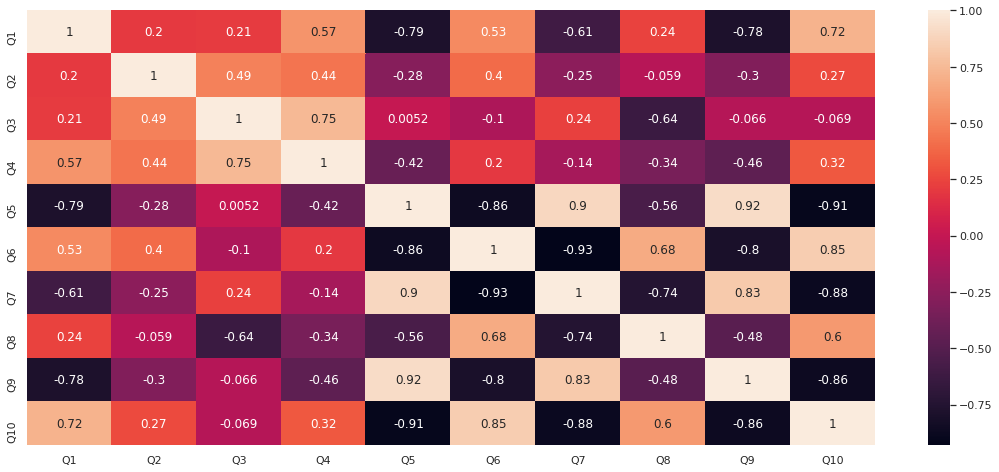

In [269]:
plt.figure(figsize=(19,8))
cor_plot = sns.heatmap(dat.drop(columns=['total_exp']).corr(), annot = True)

 Remove highly correlated explanatory variables with a threshold of 0.75:

In [270]:
import pandas as pd
import numpy as np
def find_correlation(df, thresh=0.9):
  """
    Given a numeric pd.DataFrame, this will find highly correlated features,
    and return a list of features to remove
    params:
    - df : pd.DataFrame
    - thresh : correlation threshold, will remove one of pairs of features with
               a correlation greater than this value
    @Original python code by Scott Warchal (GitHub: https://gist.github.com/Swarchal/881976176aaeb21e8e8df486903e99d6), modified by Hui Lin
  """
  corrMatrix = df.corr().abs()
  corrMatrix.loc[:,:] =  np.tril(corrMatrix, k=-1)
  already_in = set()
  result = []

  for col in corrMatrix:
    perfect_corr = corrMatrix[col][corrMatrix[col] > thresh].index.tolist()
    if perfect_corr and col not in already_in:
      already_in.update(set(perfect_corr))
      perfect_corr.append(col)
      result.append(perfect_corr)
        
  select_nested = [f[1:] for f in result]
  select_flat = [i for j in select_nested for i in j]
  return select_flat

In [286]:
removeCols = find_correlation(dat.drop(columns = ['total_exp']), thresh = 0.8)
dat2 = dat.drop(columns = removeCols)
dat2.corr()

,Q1,Q2,Q3,Q4,Q6,Q8,total_exp
Q1,1.000000,0.204073,0.211009,0.574563,0.529759,0.241402,-0.502225
Q2,0.204073,1.000000,0.491826,0.438618,0.400840,-0.058989,0.237724
Q3,0.211009,0.491826,1.000000,0.750710,-0.103039,-0.635736,0.570096
Q4,0.574563,0.438618,0.750710,1.000000,0.195380,-0.336292,0.146038
Q6,0.529759,0.400840,-0.103039,0.195380,1.000000,0.679606,-0.545836
Q8,0.241402,-0.058989,-0.635736,-0.336292,0.679606,1.000000,-0.719683
total_exp,-0.502225,0.237724,0.570096,0.146038,-0.545836,-0.719683,1.000000


In [287]:
x = dat2.drop(columns = ['total_exp'])
x = sm.add_constant(x)
y = np.log10(dat2.total_exp)

lm = sm.OLS(y, x)
lm_fit = lm.fit()
print(lm_fit.summary())

                            OLS Regression Results                            
Dep. Variable:              total_exp   R-squared:                       0.854
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     785.2
Date:                Mon, 09 Nov 2020   Prob (F-statistic):               0.00
Time:                        03:32:24   Log-Likelihood:                 734.28
No. Observations:                 811   AIC:                            -1455.
Df Residuals:                     804   BIC:                            -1422.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.5166      0.024    148.757      0.0

# Diagnostics for Linear Regression

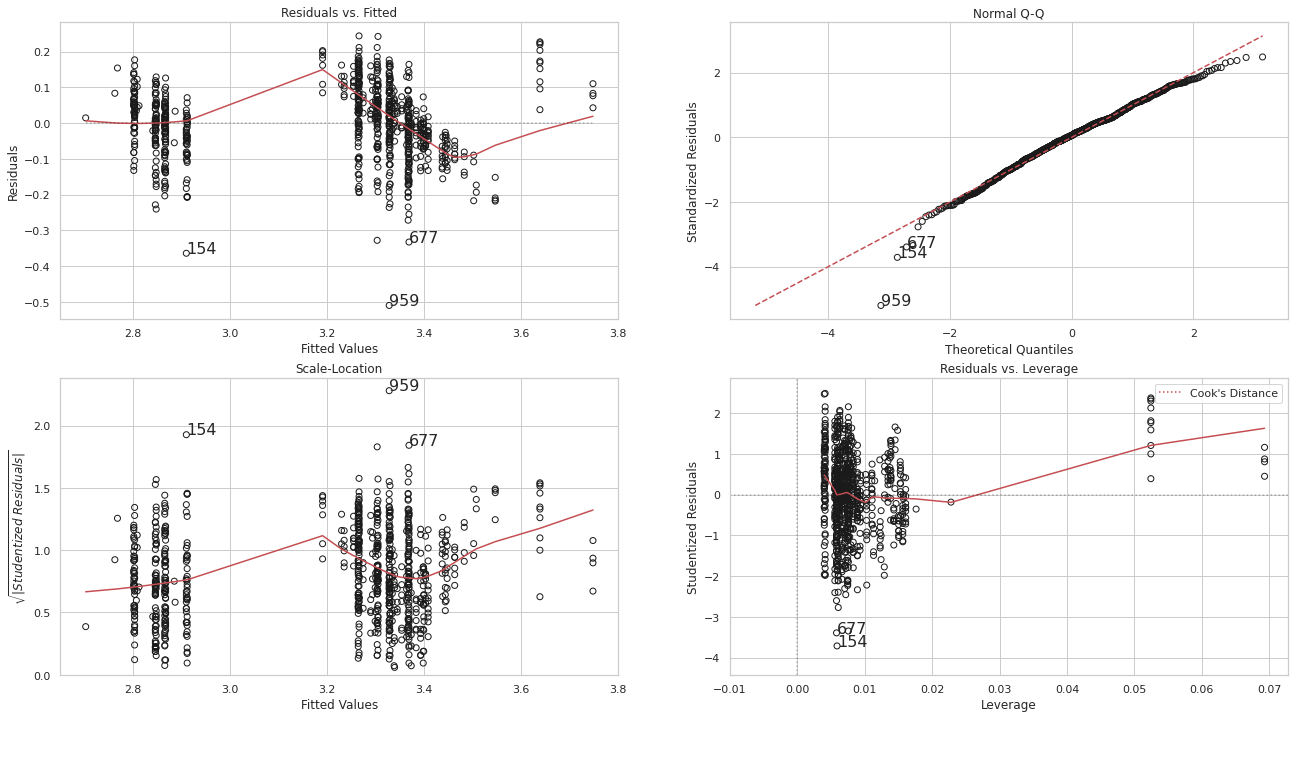

In [288]:
residuals = lm_fit.resid
fitted = lm_fit.fittedvalues
smoothed = lowess(residuals,fitted)
top3 = abs(residuals).sort_values(ascending = False)[:3]

plt.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (8,7)
fig, ax = plt.subplots(nrows = 2, ncols = 2,  figsize=(22,12))

############ residual plot
ax[0,0].scatter(fitted, residuals, edgecolors = 'k', facecolors = 'none')
ax[0,0].plot(smoothed[:,0],smoothed[:,1],color = 'r')
ax[0,0].set_ylabel('Residuals')
ax[0,0].set_xlabel('Fitted Values')
ax[0,0].set_title('Residuals vs. Fitted')
ax[0,0].plot([min(fitted),max(fitted)],[0,0],color = 'k',linestyle = ':', alpha = .3)

for i in top3.index:
    ax[0,0].annotate(i,xy=(fitted[i],residuals[i]))

############ Q-Q plot
sorted_student_residuals = pd.Series(lm_fit.get_influence().resid_studentized_internal)
sorted_student_residuals.index = lm_fit.resid.index
sorted_student_residuals = sorted_student_residuals.sort_values(ascending = True)
df = pd.DataFrame(sorted_student_residuals)
df.columns = ['sorted_student_residuals']
df['theoretical_quantiles'] = stats.probplot(df['sorted_student_residuals'], dist = 'norm', fit = False)[0]
rankings = abs(df['sorted_student_residuals']).sort_values(ascending = False)
top3 = rankings[:3]

x = df['theoretical_quantiles']
y = df['sorted_student_residuals']
ax[0,1].scatter(x,y, edgecolor = 'k',facecolor = 'none')
ax[0,1].set_title('Normal Q-Q')
ax[0,1].set_ylabel('Standardized Residuals')
ax[0,1].set_xlabel('Theoretical Quantiles')
ax[0,1].plot([np.min([x,y]),np.max([x,y])],[np.min([x,y]),np.max([x,y])], color = 'r', ls = '--')
for val in top3.index:
    ax[0,1].annotate(val,xy=(df['theoretical_quantiles'].loc[val],df['sorted_student_residuals'].loc[val]))

############ student residual plot
student_residuals = lm_fit.get_influence().resid_studentized_internal
sqrt_student_residuals = pd.Series(np.sqrt(np.abs(student_residuals)))
sqrt_student_residuals.index = lm_fit.resid.index
smoothed = lowess(sqrt_student_residuals,fitted)
top3 = abs(sqrt_student_residuals).sort_values(ascending = False)[:3]

ax[1,0].scatter(fitted, sqrt_student_residuals, edgecolors = 'k', facecolors = 'none')
ax[1,0].plot(smoothed[:,0],smoothed[:,1],color = 'r')
ax[1,0].set_ylabel('$\sqrt{|Studentized \ Residuals|}$')
ax[1,0].set_xlabel('Fitted Values')
ax[1,0].set_title('Scale-Location')
ax[1,0].set_ylim(0,max(sqrt_student_residuals)+0.1)
for i in top3.index:
    ax[1,0].annotate(i,xy=(fitted[i],sqrt_student_residuals[i]))

############ Cook’s Distance
student_residuals = pd.Series(lm_fit.get_influence().resid_studentized_internal)
student_residuals.index = lm_fit.resid.index
df = pd.DataFrame(student_residuals)
df.columns = ['student_residuals']
df['leverage'] = lm_fit.get_influence().hat_matrix_diag
smoothed = lowess(df['student_residuals'],df['leverage'])
sorted_student_residuals = abs(df['student_residuals']).sort_values(ascending = False)
top3 = sorted_student_residuals[:3]

x = df['leverage']
y = df['student_residuals']
xpos = max(x)+max(x)*0.01  
ax[1,1].scatter(x, y, edgecolors = 'k', facecolors = 'none')
ax[1,1].plot(smoothed[:,0],smoothed[:,1],color = 'r')
ax[1,1].set_ylabel('Studentized Residuals')
ax[1,1].set_xlabel('Leverage')
ax[1,1].set_title('Residuals vs. Leverage')
ax[1,1].set_ylim(min(y)-min(y)*0.15,max(y)+max(y)*0.15)
ax[1,1].set_xlim(-0.01,max(x)+max(x)*0.05)

for val in top3.index:
    ax[1,1].annotate(val,xy=(x.loc[val],y.loc[val]))

cooksx = np.linspace(min(x), xpos, 50)
p = len(results.params)
poscooks1y = np.sqrt((p*(1-cooksx))/cooksx)
poscooks05y = np.sqrt(0.5*(p*(1-cooksx))/cooksx)
negcooks1y = -np.sqrt((p*(1-cooksx))/cooksx)
negcooks05y = -np.sqrt(0.5*(p*(1-cooksx))/cooksx)

ax[1,1].plot(cooksx,poscooks1y,label = "Cook's Distance", ls = ':', color = 'r')
ax[1,1].plot(cooksx,poscooks05y, ls = ':', color = 'r')
ax[1,1].plot(cooksx,negcooks1y, ls = ':', color = 'r')
ax[1,1].plot(cooksx,negcooks05y, ls = ':', color = 'r')
ax[1,1].plot([0,0],ax[1,1].get_ylim(), ls=":", alpha = .3, color = 'k')
ax[1,1].plot(ax[1,1].get_xlim(), [0,0], ls=":", alpha = .3, color = 'k')
ax[1,1].annotate('1.0', xy = (xpos, poscooks1y[-1]), color = 'r')
ax[1,1].annotate('0.5', xy = (xpos, poscooks05y[-1]), color = 'r')
ax[1,1].annotate('1.0', xy = (xpos, negcooks1y[-1]), color = 'r')
ax[1,1].annotate('0.5', xy = (xpos, negcooks05y[-1]), color = 'r')
ax[1,1].legend()



# Principal Components Regression

Let us use the 10 survey questions (`Q1`-`Q10`) as the explanatory variables and `income` as the response variable. First load the data and preprocessing the data:

In [19]:
# load data
sim_dat = pd.read_csv("http://bit.ly/2P5gTw4")
sim_dat = sim_dat[sim_dat.income > 0]
# calculate median of the absolute dispersion for income
y = sim_dat.income
ymad = stats.median_absolute_deviation(y)
# calculate z-score
zs = (y - mean(y))/ymad
sim_dat = sim_dat[zs <= 3.5]

In [20]:
xtrain = sim_dat.filter(regex = "^Q")
ytrain = sim_dat.income

In [32]:
pca = PCA()
xtrain_pc = pca.fit_transform(scale(xtrain, axis = 0, with_mean = True, with_std = True))

Let's print out the first few variables of the first few principal components:

In [27]:
pd.DataFrame(pca.components_.T).loc[:4,:5]

,0,1,2,3,4,5
0,0.347528,-0.083611,0.512279,-0.172628,0.183858,0.658842
1,-0.100047,0.508312,-0.267229,-0.058849,0.210804,0.466175
2,-0.163582,0.507674,0.083695,0.020200,0.093503,0.119623
3,0.038456,0.479928,0.431846,-0.228330,0.319326,-0.544996
4,-0.425154,-0.083809,-0.100016,0.101061,0.205063,0.093502


Now we'll perform 10-fold cross-validation to see how it influences the MSE:

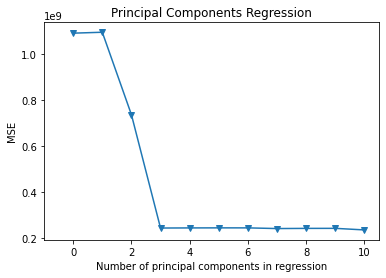

In [37]:
# 10-fold CV, with shuffle
n = len(xtrain_pc)
kf10 = ms.KFold( n_splits=10, shuffle = True, random_state = 100)

lm = LinearRegression()
mse = []

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*ms.cross_val_score(lm, np.ones((n,1)), ytrain.ravel(), cv = kf10, scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using CV for the 10 principle components, adding one component at the time.
for i in np.arange(1, 11):
    score = -1*model_selection.cross_val_score(lm, xtrain_pc[:,:i], ytrain.ravel(), cv = kf10, scoring='neg_mean_squared_error').mean()
    mse.append(score)
    
# Plot results    
plt.plot(mse, '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Principal Components Regression')
plt.xlim(xmin=-1);

There is only minimum improvement in MSE after 3 components.

# Partial Least Square

Scikit-learn `PLSRegression` gives same results as the `pls` package in R when using `method='oscorespls'`.  However, the standard method used is `kernelpls`, which we will use here. Feel free to try out both.

(-1.0, 10.45)

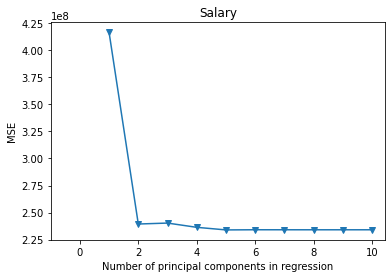

In [43]:
n = len(xtrain)

# 10-fold CV, with shuffle
kf10 = model_selection.KFold(n_splits=10, shuffle = True, random_state = 100)

mse = []

for i in np.arange(1, 11):
    pls = PLSRegression(n_components = i)
    score = ms.cross_val_score(pls, scale(xtrain, axis = 0, with_mean= True, with_std=True), ytrain, cv=kf10, scoring='neg_mean_squared_error').mean()
    mse.append(-score)

# Plot results
plt.plot(np.arange(1, 11), np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1)

From the output, we see little difference after the model with 5 components. 